Adding to sys.path: /Users/mauriciotano/projects/jax-cfd-tests/notebooks/processing_mstdb
Loading data from: /Users/mauriciotano/projects/jax-cfd-tests/notebooks/processing_mstdb/data/mstdb_processed.csv


,System,id,Mol Mass,Mol Frac,Melt(K),Var(%),Reference,Boil(K),Var(%) .1,Reference,rho_a,rho_b,range(K),Var(%) .2,Reference,mu1_a,mu1_b,mu2_a,mu2_b,mu2_c,range(K) .1,Var(%) .3,Reference,k_a,k_b,range(K),Var(%) .4,Reference .1,cp_a,cp_b,cp_c,cp_d,Var(%) .5,Reference,Composition
0,AlCl3,1,133.3405,Pure Salt,465,----,Kelley 1935 [74],453,----,Janz 1967 [66],2.5600,0.002710,462-569,1,King 1971 [78],2.280000e-03,19400.00,NaN,NaN,NaN,469-559,1,Brockner 1979 [28],NaN,NaN,----,----,----,125.520,NaN,NaN,NaN,----,Robelin 2004 [119],"{'Al': 0.25, 'Cl': 0.75}"
1,BeCl2,2,79.9182,Pure Salt,688,2,McDonald 1965 [92],760,----,Brewer 1963 [26],2.2800,0.001100,706-746,5,Klemm 1926 [81],NaN,NaN,NaN,NaN,NaN,----,----,----,NaN,NaN,----,----,----,NaN,NaN,NaN,NaN,----,----,"{'Be': 0.3333333333333333, 'Cl': 0.66666666666..."
2,BeF2,3,47.009,Pure Salt,821.2,3,Thoma 1960 [139],1442,----,Cantor 1965 [31],1.9700,0.000015,1073-1123,1,Cantor 1969 [33],NaN,NaN,-8.120,11500.0,639000.0,846.9-1252.2,3,Moynihan 1968 [98],0.801,-0.000002,1070.15-1500,20,Gheribi 2014 [58],51.100,0.0346,NaN,NaN,----,Chase 1998 [36],"{'Be': 0.3333333333333333, 'F': 0.666666666666..."
3,CaCl2,4,110.984,Pure Salt,1045,10,Moore 1943 [96],2230,30,Glushko 1972 [61],2.5300,0.000423,1060-1223,1,Yaffe 1956 [152],NaN,NaN,-0.545,597.0,546000.0,987-1239,1,Toerklep 1982 [140],0.568,-0.000115,1055.15-1700,20,Gheribi 2014 [58],102.533,NaN,NaN,NaN,10,Moore 1943 [96],"{'Ca': 0.3333333333333333, 'Cl': 0.66666666666..."
4,CaF2,5,78.0748,Pure Salt,1692,1,Mukerji 1965 [99],2724,----,Ruff 1928 [123],3.1800,0.000391,1640-2300,3,Kirshenbaum 1960 [80],1.000000e-01,47600.00,NaN,NaN,NaN,1703.3-1868.1,3,Takeda 2015 [135],0.667,-0.000060,1691.15-2500,20,Gheribi 2014 [58],99.914,NaN,NaN,NaN,10,Naylor 1945 [103],"{'Ca': 0.3333333333333333, 'F': 0.666666666666..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4872,ZnCl2,4873,----,Pure Salt,----,----,----,----,----,----,2.8375,0.000529,----,----,----,9.818701e-05,96325.38,NaN,NaN,NaN,----,----,----,NaN,NaN,----,----,----,NaN,NaN,NaN,NaN,----,----,"{'Zn': 0.3333333333333333, 'Cl': 0.66666666666..."
4873,ZnI2,4874,----,Pure Salt,----,----,----,----,----,----,4.8560,0.001360,----,----,----,NaN,NaN,NaN,NaN,NaN,----,----,----,NaN,NaN,----,----,----,NaN,NaN,NaN,NaN,----,----,"{'Zn': 0.3333333333333333, 'I': 0.666666666666..."
4874,ZnSO4,4875,----,Pure Salt,----,----,----,----,----,----,3.5910,0.000470,----,----,----,NaN,NaN,NaN,NaN,NaN,----,----,----,NaN,NaN,----,----,----,NaN,NaN,NaN,NaN,----,----,"{'Zn': 0.16666666666666666, 'S': 0.16666666666..."
4875,ZrCl4,4876,----,Pure Salt,----,----,----,----,----,----,6.9430,0.007465,----,----,----,5.100820e-07,80116.57,NaN,NaN,NaN,----,----,----,NaN,NaN,----,----,----,NaN,NaN,NaN,NaN,----,----,"{'Zr': 0.2, 'Cl': 0.8}"


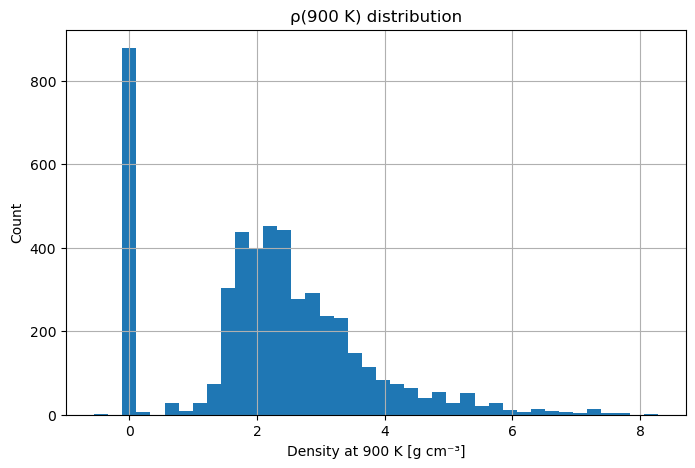

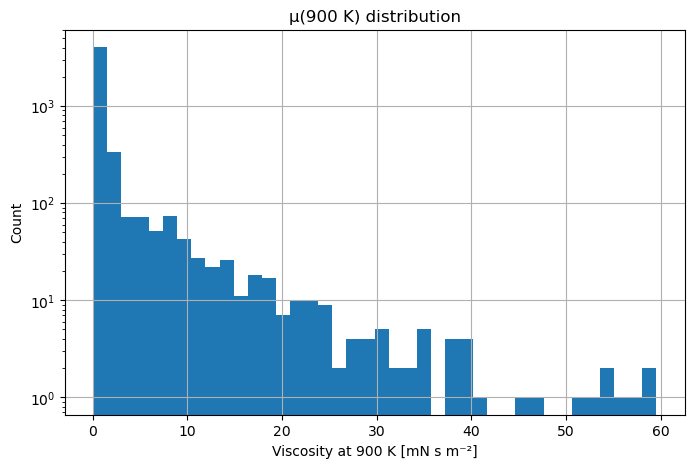

In [4]:
"""
Extended MSTDB + Janz ingestion script
--------------------------------------
This version hardens compute_composition so mismatched or malformed
fraction strings are handled gracefully instead of raising.
"""

import os, sys, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from typing import Union, Optional
from types import MethodType

# ─────────────────────────────  paths / constants  ──────────────────────
PROJECT_PATH = os.path.abspath(os.path.join(os.getcwd(), ".."))
print("Adding to sys.path:", PROJECT_PATH)
sys.path.insert(0, PROJECT_PATH)

from processing_mstdb.processor import MSTDBProcessor

T = 900.0                              # K
R = 8.31441                            # J·mol⁻¹·K⁻¹
PLACEHOLDER = "----"

# ─────────────────────────────  helpers  ────────────────────────────────
def normalise_comp(x: Union[str, float, int, None]) -> Optional[str]:
    """Convert % strings to fractions that sum to 1, ensuring no scientific notation."""
    if pd.isna(x):
        return None
    s = str(x).strip()
    s = re.sub(r"[–—−]", "-", s)

    def format_float(val: float) -> str:
        """Format float to string without scientific notation or trailing zeros."""
        formatted = "{:.6f}".format(val)
        # Remove trailing zeros and ensure at least one decimal place
        parts = formatted.split('.')
        if len(parts) == 1:
            return f"{parts[0]}.0"
        integer_part, decimal_part = parts
        decimal_part = decimal_part.rstrip('0')
        if len(decimal_part) == 0:
            return f"{integer_part}.0"
        return f"{integer_part}.{decimal_part}"

    if "-" in s:
        parts = [p for p in re.split(r"\s*-\s*", s) if p != ""]
        if len(parts) != 2:
            return None
        try:
            a, b = float(parts[0]), float(parts[1])
        except ValueError:
            return None
        if np.isclose(a + b, 100, atol=0.2):
            a, b = a / 100, b / 100
        return f"{format_float(a)}-{format_float(b)}"
    else:
        try:
            val = float(s)
        except ValueError:
            return None
        if np.isclose(val, 100, atol=0.2):
            val /= 100
        return format_float(val)

# ─────────────────────────────  read Janz csvs  ─────────────────────────
density_df = (
    pd.read_csv("density-csv.csv", skiprows=1).iloc[:-4]
      .rename(columns={"Salt": "System",
                       "Data 1": "rho_a", "Data 2": "rho_b",
                       "Composition range": "Mol Frac"})
)
density_df[["rho_a", "rho_b"]] = density_df[["rho_a", "rho_b"]].apply(
    pd.to_numeric, errors="coerce")
density_df["rho_b"] *= -1.0

viscosity_df = (
    pd.read_csv("viscosity-csv.csv", skiprows=1).iloc[:-4]
      .rename(columns={"Salt": "System",
                       "Data 1": "mu1_a", "Data 2": "mu1_b",
                       "Composition range": "Mol Frac"})
)
viscosity_df[["mu1_a", "mu1_b"]] = viscosity_df[["mu1_a", "mu1_b"]].apply(
    pd.to_numeric, errors="coerce")

# ─────────────────────────────  tidy & merge  ───────────────────────────
dens = density_df[["System", "Mol Frac", "rho_a", "rho_b"]].copy()
visc = viscosity_df[["System", "Mol Frac", "mu1_a", "mu1_b"]].copy()

dens["Mol Frac"] = dens["Mol Frac"].apply(normalise_comp)
visc["Mol Frac"] = visc["Mol Frac"].apply(normalise_comp)

dens_single = dens.groupby(["System", "Mol Frac"], as_index=False).mean()
visc_single = visc.groupby(["System", "Mol Frac"], as_index=False).mean()

janz_props = (
    pd.merge(dens_single, visc_single, on=["System", "Mol Frac"], how="outer")
      .sort_values(["System", "Mol Frac"])
      .reset_index(drop=True)
)

# placeholder only in object columns
obj_cols = janz_props.select_dtypes(include="object").columns
janz_props[obj_cols] = janz_props[obj_cols].fillna(PLACEHOLDER)

# mark pure salts
janz_props.loc[janz_props["Mol Frac"].isin(["1", 1, 1.0, "1.0"]),
               "Mol Frac"] = "Pure Salt"

# ─────────────────────────────  load master MSTDB  ──────────────────────
data_path = os.path.join(PROJECT_PATH, "data/mstdb_processed.csv")
print("Loading data from:", data_path)
processor = MSTDBProcessor.from_csv(data_path)
processor.df.columns = processor.df.columns.str.strip()

# align columns
for col in processor.df.columns:
    if col not in janz_props.columns:
        janz_props[col] = PLACEHOLDER
janz_props = janz_props[processor.df.columns]

# unique IDs
if "id" in processor.df.columns:
    last_id = processor.df["id"].max(skipna=True)
    last_id = 0 if pd.isna(last_id) else int(last_id)
    janz_props["id"] = range(last_id + 1, last_id + 1 + len(janz_props))

# concat
processor.df = pd.concat([processor.df, janz_props], ignore_index=True)

# ───────────────────  drop unrealistically high viscosity  ──────────────
mu1_a_num = pd.to_numeric(processor.df["mu1_a"], errors="coerce")
mu1_b_num = pd.to_numeric(processor.df["mu1_b"], errors="coerce")
visc900 = mu1_a_num.fillna(0.0) * np.exp(mu1_b_num.fillna(0.0) / (R*T))
processor.df.loc[visc900 > 60.0, ["mu1_a", "mu1_b"]] = PLACEHOLDER

# keep numeric dtypes intact
numeric_cols = ["rho_a", "rho_b", "mu1_a", "mu1_b",
                "mu2_a", "mu2_b", "mu2_c",
                "k_a", "k_b", "cp_a", "cp_b", "cp_c", "cp_d"]
processor.df[numeric_cols] = processor.df[numeric_cols].apply(
    pd.to_numeric, errors="coerce")

# ───────────────────  robust compute_composition  ───────────────────────
def safe_compute_composition(self, row, composition_type="elements"):
    system   = row["System"]
    mol_frac = "" if pd.isna(row["Mol Frac"]) else str(row["Mol Frac"]).strip()
    compounds = system.split("-")
    n = len(compounds)

    # fallback for blank / placeholder
    if mol_frac in ("", PLACEHOLDER):
        fractions = [1.0/n]*n if n > 1 else [1.0]

    elif mol_frac == "Pure Salt":
        fractions = [1.0]

    else:   # attempt to parse the numbers
        try:
            parts = [p for p in mol_frac.split("-") if p != ""]
            fractions = [float(x) for x in parts]
        except ValueError:
            fractions = [1.0/n]*n
        if len(fractions) != n:
            fractions = [1.0/n]*n

    compound_dict = dict(zip(compounds, fractions))

    # build elemental composition
    total = {}
    for comp, frac in compound_dict.items():
        for el, cnt in self.parse_compound(comp).items():
            total[el] = total.get(el, 0) + frac*cnt
    s = sum(total.values())
    elem_dict = {el: cnt/s for el, cnt in total.items()} if s else {}

    if composition_type == "elements":
        return elem_dict
    if composition_type == "compounds":
        return compound_dict
    if composition_type == "both":
        return {**elem_dict, **compound_dict}
    raise ValueError("Invalid composition_type")

# monkey-patch
processor.compute_composition = MethodType(safe_compute_composition, processor)

processor.df["Composition"] = processor.df.apply(
    lambda r: processor.compute_composition(r, composition_type="elements"), axis=1
)

# ───────────────────  export & simple histograms  ───────────────────────
display(processor.df)
processor.df.to_csv("mstdb_janz_processed.csv", index=False)

df = processor.df.copy(deep=True)
df[numeric_cols[:4]] = df[numeric_cols[:4]].apply(pd.to_numeric, errors="coerce")

rho_a = df["rho_a"].fillna(0.0)
rho_b = df["rho_b"].fillna(0.0)
mu1_a = df["mu1_a"].fillna(0.0)
mu1_b = df["mu1_b"].fillna(0.0)

density_900   = rho_a - rho_b*T
viscosity_900 = mu1_a * np.exp(mu1_b / (R*T))

plt.figure(figsize=(8,5))
plt.hist(density_900, bins=40)
plt.xlabel("Density at 900 K [g cm⁻³]"); plt.ylabel("Count")
plt.title("ρ(900 K) distribution"); plt.grid(True)

plt.figure(figsize=(8,5))
plt.hist(viscosity_900, bins=40)
plt.xlabel("Viscosity at 900 K [mN s m⁻²]"); plt.ylabel("Count")
plt.yscale("log"); plt.title("μ(900 K) distribution"); plt.grid(True)

plt.show()


In [4]:
list(processor.df['Mol Frac'])

['Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 'Pure Salt',
 '0.20-0.80',
 '0.333-0.667',
 '0.50-0.50',
 '0.667-0.333',
 '0.743-0.257',
 '0.817-0.183',
 '0.885-0.115',
 '0.945-0.055',
 '0.1523-0.8477',
 '0.2706-0.7294',
 '0.3485-0.6515',
 '0.4877-0.5123',
 '0.5900-0.4100',
 '0.7925-0.2075',
 '0.10-0.90',
 '0.226-0.774',
 '0.325-0.675',
 '0.337-0.663',
 '0.383-0.617',
 '0.46-0.54',
 '0.465-0.535',
 '0.497-0.503',
 '0.501-0.499',
 '0.561-0.439',
 '0.578-0.422',
 '0.657-0.343',
 '0.672-0.328',
 '0.676-0.324',
 '0.68-0.32',
 '0.75-0.25',
 '0.836-0.164',
 '0.88-0.12',
 '0.92-0.08',
 '0.934-0.066'